Cousin Antoine
MNIST NNs for Ummon HealthTech

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

# Dataset

In [25]:
transform = transforms.Compose([transforms.Resize(16),transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

In [26]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [27]:
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [28]:
len(mnist_train)

60000

In [29]:
len(mnist_testset)

10000

In [30]:
trainloader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=4, num_workers=2)

In [31]:
testloader = torch.utils.data.DataLoader(mnist_testset, shuffle=False, batch_size=4)

In [32]:
classes = ('zero', 'one', 'two', 'three', 'four','five', 'six', 'seven', 'eight', 'nine') 

Data visualisation:

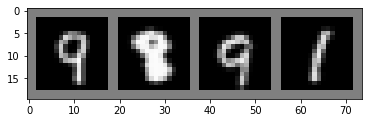

 nine eight  nine   one


In [33]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# CNN
Based on : https://www.sciencedirect.com/science/article/pii/S1672022921000401 model

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fc1 = nn.Linear(1024,10)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, self.num_flat_features(x)) 
        x = self.fc1(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)


In [35]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [36]:
def train(epochs = 10):
    for epoch in range(epochs):
        running_loss = 0.0
        for _, data in enumerate(trainloader,0):
            inputs, labels = data
            
            optimizer.zero_grad()
            outputs = cnn(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print('{} loss: {}'.format(epoch+1, running_loss/60000))
    print('Finished Training')

In [37]:
train()

1 loss: 0.050730459113858324
2 loss: 0.019097817536019527
3 loss: 0.01447750618369035
4 loss: 0.011862330967632876
5 loss: 0.010005509019240919
6 loss: 0.009017280534155415
7 loss: 0.007799739181653665
8 loss: 0.0071013980236754775
9 loss: 0.0061440616707758204
10 loss: 0.005449425633417661
Finished Training


In [38]:
torch.save(cnn.state_dict(), './cnn.pth')

## Test

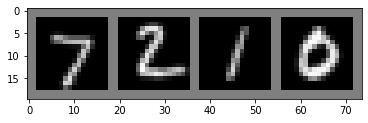

seven   two   one  zero


In [39]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [40]:
outputs = cnn(images)
_,predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  seven   two   one  zero


In [41]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs =  cnn(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted==labels).sum().item()
    
print('Accuracy on test set : {}%'.format(100*correct/total))

Accuracy on test set : 98.69%


# CAE

In [42]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE,self).__init__()
        
        self.encode= nn.Sequential(
            nn.Conv2d(1,16,3,stride=3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(16,8,3,stride=2,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2,stride=1))
        
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(8,16,3,stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,8,5,stride=3,padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8,1,2,stride=2,padding=1),
            nn.Tanh())
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
cae = CAE().cuda()
print(cae)

CAE(
  (encode): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decode): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)


In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cae.parameters(),lr=0.001)

In [44]:
device = 'cpu'
cae.to(device)

def train2(epochs=100):
    for epoch in range(epochs):
        train_loss = 0.0
        for data in trainloader:
            img, _ = data
            
            optimizer.zero_grad()
            
            output = cae(img)
            loss = criterion(output,img)
            
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*img.size(0)
        train_loss = train_loss/len(trainloader)
        print('{} loss : {}'.format(epoch+1, train_loss))
    print('Finished Training')

In [45]:
train2()

1 loss : 0.39195643154978754
2 loss : 0.28074889346063137
3 loss : 0.2633247925490141
4 loss : 0.25438771029313406
5 loss : 0.24811567648748556
6 loss : 0.24341768341163794
7 loss : 0.2397207737925152
8 loss : 0.23668601657971738
9 loss : 0.23429028966700038
10 loss : 0.23225521601165333
11 loss : 0.23067255604316791
12 loss : 0.2294494609725972
13 loss : 0.2283729208442072
14 loss : 0.22738385990758736
15 loss : 0.22665086568146944
16 loss : 0.22595987191423775
17 loss : 0.22537018016998966
18 loss : 0.22472144077296058
19 loss : 0.22416907138278086
20 loss : 0.22351624264692266
21 loss : 0.2231911582238972
22 loss : 0.22267726325293383
23 loss : 0.22234727513243754
24 loss : 0.22181474841212234
25 loss : 0.2214478208998839
26 loss : 0.22121961458548903
27 loss : 0.220872420612971
28 loss : 0.22069042395502328
29 loss : 0.22047474496662617
30 loss : 0.22000564229687056
31 loss : 0.219778375629584
32 loss : 0.21956136793345213
33 loss : 0.21931064546083412
34 loss : 0.2190134742423892


In [46]:
torch.save(cnn.state_dict(), './cae.pth')

## Test

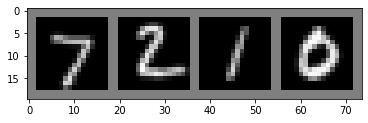

In [66]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

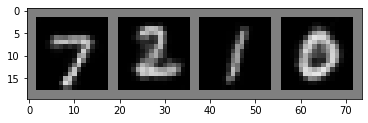

In [67]:
outputs = cae(images)
imshow(torchvision.utils.make_grid(outputs))

## Ajout de bruit

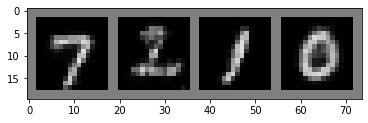

In [87]:
inter_images = cae.encode(images)
noise = torch.randn_like(inter_images)*0.5
outputs = cae.decode(inter_images+noise)
imshow(torchvision.utils.make_grid(outputs))

In [89]:
def encode_noise_decode(images, noise=0.1):
    inter_images = cae.encode(images)
    noise = torch.randn_like(inter_images)*noise
    outputs = cae.decode(inter_images+noise)
    return outputs

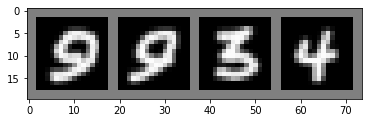

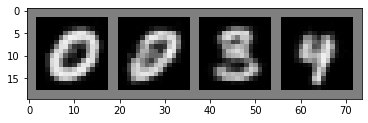

In [91]:
criterion = nn.MSELoss()

max_loss = 0

for data in testloader:
    images,_ = data
    outputs = encode_noise_decode(images)
    loss = criterion(outputs, images)
    if max_loss < loss.item():
        saved_images = [outputs,images]
        max_loss = loss.item()
        
imshow(torchvision.utils.make_grid(saved_images[1]))
imshow(torchvision.utils.make_grid(saved_images[0]))

Batch avec la plus grande variation

In [93]:
outputs = cnn(saved_images[1])
_,predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

outputs = cnn(saved_images[0])
_,predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   nine  nine three  four
Predicted:   zero  zero three  four


Les images correspondant a un 9 de base se retrouvent transformées en 0.
Avec du bruit avant le décodage, celui-ci peut se retrouver faussé dans le cas de formes proches.